[View in Colaboratory](https://colab.research.google.com/github/ramyaragupathy/mlblr-eip/blob/master/RAMYA_RAGUPATHY_BATCH_A_CYCLEGAN.ipynb)

[Source Paper](https://github.com/junyanz/CycleGAN/)

# Generative Adversarial Network (GAN)

Core of GAN has 2 neural network models:

 - discriminator (D) &
 - generator (G)
 
 GAN is modelled such that generator & discriminator compete/wrestle against one another. Discriminator has to recognise a particular type of image while the Generator keeps generating images good enough to pass through the discriminator lens.
 
## Image-to-Image Translation

# Cycle GAN




# **Dependencies**

* OS module in Python provides way to use Operation System functionality. Here environment variables are updated using the improted module.
* Keras provides the KERAS_BACKEND environment variable using which backend could be chosen.
* Similarly THEANO_FLAGS environment variable are also set. 
* The environment varibales are configuration setting that cannot be changed after importing theano/keras




In [0]:
import os
os.environ['KERAS_BACKEND']='theano' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [32]:
!pip install theano

In [0]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

In [0]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [0]:

# Weights initializations# Weigh 
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization

In [0]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [0]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, None, None))
    else:
        input_a = Input(shape=(None, None, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1), 
               activation = "sigmoid" if use_sigmoid else None) (_)    
    return Model(inputs=[input_a], outputs=_)

In [0]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2, use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

ngf = 64 # Number of filters in first layer of generator

ndf = 64 # Number of filters in first layer of discriminator

In [0]:
nc_in = 3
nc_out = 3
ngf = 64
ndf = 64
use_lsgan = True
λ = 10 if use_lsgan else 100

loadSize = 143
imageSize = 128
batchSize = 1
lrD = 2e-4
lrG = 2e-4

In [40]:
netDA  =  BASIC_D(nc_in, ndf, use_sigmoid = not use_lsgan)
netDB = BASIC_D(nc_out, ndf, use_sigmoid = not use_lsgan)
netDA.summary()

use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 1)
use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3, None, None)     0         
_________________________________________________________________
First (Conv2D)               (None, 64, None, None)    3136      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, None, None)    0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, 128, None, None)   131072    
_________________________________________________________________
batch_normalization_29 (Batc (None, 128, None, None)   512    

In [41]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


netGB = UNET_G(imageSize, nc_in, nc_out, ngf)
netGA = UNET_G(imageSize, nc_out, nc_in, ngf)
#SVG(model_to_dot(netG, show_shapes=True).create(prog='dot', format='svg'))
netGA.summary()

use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 256, 1024)
use reshape (4, 4, 128, 512)
use reshape (4, 4, 64, 256)
use reshape (4, 4, 3, 128)
use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 256, 1024)
use reshape (4, 4, 128, 512)
use reshape (4, 4, 64, 256)
use reshape (4, 4, 3, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                    

In [0]:

from  keras.optimizers import RMSprop, SGD, Adam

In [43]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_A, fake_B, rec_A, cycleA_generate = cycle_variables(netGB, netGA)
real_B, fake_A, rec_B, cycleB_generate = cycle_variables(netGA, netGB)

use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 256, 1024)
use reshape (4, 4, 128, 512)
use reshape (4, 4, 64, 256)
use reshape (4, 4, 3, 128)
use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 512)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 512, 1024)
use reshape (4, 4, 256, 1024)
use reshape (4, 4, 128, 512)
use reshape (4, 4, 64, 256)
use reshape (4, 4, 3, 128)


In [44]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DA, loss_GA, loss_cycA = D_loss(netDA, real_A, fake_A, rec_A)
loss_DB, loss_GB, loss_cycB = D_loss(netDB, real_B, fake_B, rec_B)
loss_cyc = loss_cycA+loss_cycB

use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 1)
use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 1)
use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 1)
use reshape (4, 4, 3, 64)
use reshape (4, 4, 64, 128)
use reshape (4, 4, 128, 256)
use reshape (4, 4, 256, 512)
use reshape (4, 4, 512, 1)


In [0]:

loss_G = loss_GA+loss_GB+λ*loss_cyc
loss_D = loss_DA+loss_DB

weightsD = netDA.trainable_weights + netDB.trainable_weights
weightsG = netGA.trainable_weights + netGB.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_A, real_B],[loss_DA/2, loss_DB/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_GA, loss_GB, loss_cyc], training_updates)

### Training Images

trainA: train images for the class A (horses)

trainB: train images for the class B (zebras)


In [56]:
from PIL import Image
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern)

def read_image(fn):
    im = Image.open(fn).convert('RGB')
    im = im.resize( (loadSize, loadSize), Image.BILINEAR )
    arr = np.array(im)/255*2-1
    w1,w2 = (loadSize-imageSize)//2,(loadSize+imageSize)//2
    h1,h2 = w1,w2
    img = arr[h1:h2, w1:w2, :]
    if randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

#data = "edges2shoes"
data = "horse2zebra"

train_A = load_data('horse2zebra/trainA/*.jpg'.format(data))
train_B = load_data('horse2zebra/trainB/*.jpg'.format(data))

print(len(train_A))
print(len(train_B))

1067
1334


In [0]:
def minibatch(data, batchsize):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j]) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       

def minibatchAB(dataA, dataB, batchsize):
    batchA=minibatch(dataA, batchsize)
    batchB=minibatch(dataB, batchsize)
    tmpsize = None    
    while True:        
        ep1, A = batchA.send(tmpsize)
        ep2, B = batchB.send(tmpsize)
        tmpsize = yield max(ep1, ep2), A, B

In [0]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    if channel_first:
        int_X = np.moveaxis(int_X.reshape(-1,3,imageSize,imageSize), 1, 3)
    else:
        int_X = int_X.reshape(-1,imageSize,imageSize, 3)
    int_X = int_X.reshape(rows, -1, imageSize, imageSize,3).swapaxes(1,2).reshape(rows*imageSize,-1, 3)
    display(Image.fromarray(int_X))

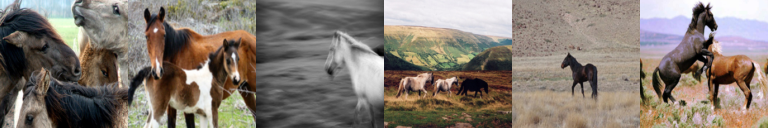

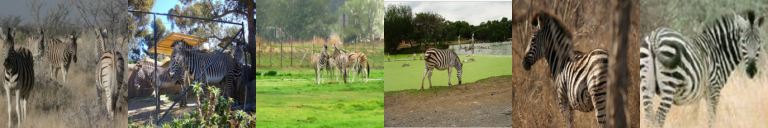

In [59]:
train_batch = minibatchAB(train_A, train_B, 6)

_, A, B = next(train_batch)
showX(A)
showX(B)
del train_batch, A, B

In [0]:
def showG(A,B):
    assert A.shape==B.shape
    def G(fn_generate, X):
        r = np.array([fn_generate([X[i:i+1]]) for i in range(X.shape[0])])
        return r.swapaxes(0,1)[:,:,0]        
    rA = G(cycleA_generate, A)
    rB = G(cycleB_generate, B)
    arr = np.concatenate([A,B,rA[0],rB[0],rA[1],rB[1]])
    showX(arr, 3)

[0/150][900] Loss_D: 0.284871 0.290813 Loss_G: 0.336320 0.427129 loss_cyc 0.271356 7188.157832622528


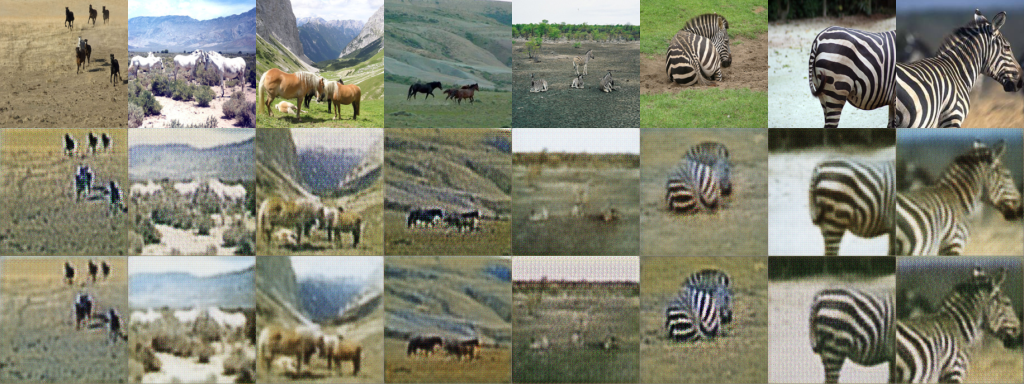

In [0]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 150
gen_iterations = 0
epoch = 0
errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0

display_iters = 50
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchAB(train_A, train_B, batchSize)

while epoch < niter: 
    epoch, A, B = next(train_batch)        
    errDA, errDB  = netD_train([A, B])
    errDA_sum +=errDA
    errDB_sum +=errDB

    # epoch, trainA, trainB = next(train_batch)
    errGA, errGB, errCyc = netG_train([A, B])
    errGA_sum += errGA
    errGB_sum += errGB
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDA_sum/display_iters, errDB_sum/display_iters,
           errGA_sum/display_iters, errGB_sum/display_iters, 
           errCyc_sum/display_iters), time.time()-t0)
        _, A, B = train_batch.send(4)
        showG(A,B)        
        errCyc_sum = errGA_sum = errGB_sum = errDA_sum = errDB_sum = 0